In [2]:
import pandas as pd

# Charger les données JSON contenant les avis clients
df = pd.read_json('reviews.jsonl', lines=True)

# Extraire les colonnes pertinentes : texte des avis et notes réelles (ratings)
df = df[['text', 'rating']].dropna()

# Convertir les notes en entiers
df['rating'] = df['rating'].astype(int)  

# Vérification des données
print(f"Aperçu des données :\n{df.head()}")


Aperçu des données :
                                                text  rating
0  I bought this bc I thought it had the nice whi...       4
1  Perfect. How pissed am I that I recently paid ...       5
2  Overall very happy with the end result. If you...       5
3  Lasted about 9 months then the lock button bro...       4
4  LOVE THIS CASE! Works better than my expensive...       5


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Charger le modèle et le tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Prétratiement des données
from torch.utils.data import DataLoader, Dataset
import torch

# Classe Dataset pour préparer les données
class ReviewsDataset(Dataset):
    def __init__(self, texts, ratings):
        self.texts = texts
        self.ratings = ratings

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'rating': self.ratings[idx]
        }

# Préparer les données
dataset = ReviewsDataset(df['text'].tolist(), df['rating'].tolist())
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
#Analyse des sentiments
from torch.nn.functional import softmax

# Détecter le dispositif (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predicted_ratings = []

# Analyse des sentiments
for batch in dataloader:
    texts = batch['text']
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Obtenir les prédictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1) + 1  # Ajouter 1 pour correspondre aux étoiles
        predicted_ratings.extend(predictions.cpu().numpy())

# Ajouter les prédictions au DataFrame
df['predicted_rating'] = predicted_ratings
print(f"Aperçu des résultats :\n{df[['rating', 'predicted_rating']].head(15)}")

Aperçu des résultats :
    rating  predicted_rating
0        4                 3
1        5                 5
2        5                 4
3        4                 2
4        5                 5
5        5                 5
6        5                 5
7        4                 5
8        5                 5
9        5                 4
10       5                 5
11       5                 5
12       5                 5
13       5                 3
14       4                 4


In [6]:
#Performance du modèle 
# Méthode : Corrélation de Pearson, qui mesure la force de la relation linéaire entre deux variables continues 
#un score proche de 1 indique une relation positive forte

from scipy.stats import pearsonr

# Calculer la corrélation de Pearson entre les notes réelles et prédites
real_ratings = df['rating'].astype(float)
predicted_ratings = df['predicted_rating'].astype(float)
correlation, _ = pearsonr(real_ratings, predicted_ratings)
print(f"Corrélation de Pearson entre les notes réelles et prédites : {correlation:.3f}")

Corrélation de Pearson entre les notes réelles et prédites : 0.817


###  Distribution des notes réelles et prédites

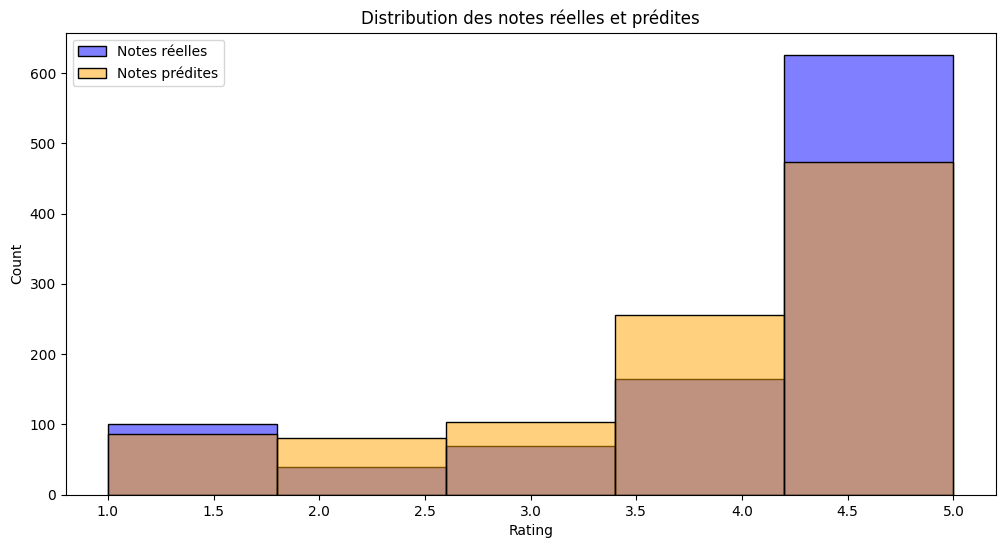

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(df['rating'], bins=5, color='blue', alpha=0.5, label='Notes réelles')
sns.histplot(df['predicted_rating'], bins=5, color='orange', alpha=0.5, label='Notes prédites')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution des notes réelles et prédites')
plt.legend()
plt.show()

### Matrice de confusion

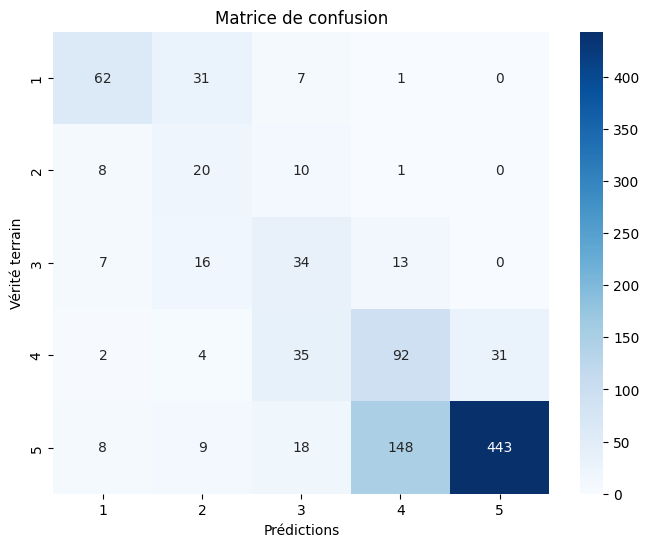

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df['rating'], df['predicted_rating'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()


### Analyse des erreurs

C:\Users\ghebr\AppData\Local\Temp\ipykernel_6584\3901268172.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.index, y=error_counts.values, palette='viridis')


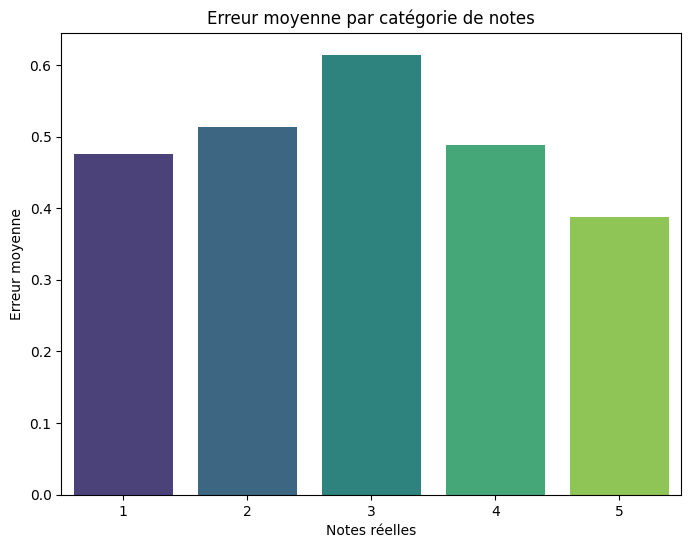

In [8]:
df['error'] = abs(df['rating'] - df['predicted_rating'])
error_counts = df.groupby('rating')['error'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=error_counts.index, y=error_counts.values, palette='viridis')
plt.xlabel('Notes réelles')
plt.ylabel('Erreur moyenne')
plt.title('Erreur moyenne par catégorie de notes')
plt.show()


### Proportion des prédictions exactes

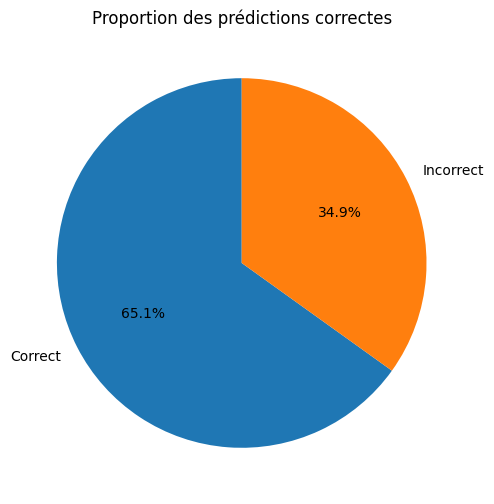

In [9]:
correct_predictions = (df['rating'] == df['predicted_rating']).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions

labels = ['Correct', 'Incorrect']
sizes = [accuracy, 1 - accuracy]
colors = ['#1f77b4', '#ff7f0e']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion des prédictions correctes')
plt.show()